# TME3-  Descente de gradient, Perceptron 

In [1]:
from arftools import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
def mse(datax, datay, w):
    """ retourne la moyenne de l'erreur aux moindres carres """
    m = len(datay)
    w = w.reshape(-1)
    datax, datay = datax.reshape(len(datay), -1), datay.reshape(-1)
    if len(datax.shape) == 1:
        datax = datax.reshape(1, -1)

    pred = np.dot(datax, w)
    loss = (1/(2*m)) * ((pred-datay)**2).sum()
    return loss

In [3]:
def mse_g(datax, datay, w):
    """ retourne le gradient moyen de l'erreur au moindres carres """
    w = w.reshape(-1)
    m = len(datay)
    datax, datay = datax.reshape(len(datay), -1), datay.reshape(-1)
    if len(datax.shape) == 1:
        datax = datax.reshape(1, -1)

    grad = (1/m)*np.dot(datax.T, np.dot(datax, w)-datay)
    return grad

In [4]:
def hinge(datax, datay, w):
    """ retourn la moyenne de l'erreur hinge """
    w = w.reshape(-1)
    datax, datay = datax.reshape(len(datay), -1), datay.reshape(-1)

    if len(datax.shape) == 1:
        datax = datax.reshape(1, -1)

    r = np.dot(datax, w)*-1*datay
    return np.maximum(np.zeros(r.shape), r).mean()

In [5]:
def hinge_g(datax, datay, w):
    """ retourne le gradient moyen de l'erreur hinge """
    out = np.zeros(datax.shape)
    w = w.reshape(-1)
    datax, datay = datax.reshape(len(datay), -1), datay.reshape(-1)
    if len(datax.shape) == 1:
        datax = datax.reshape(1, -1)

    r = datay*np.dot(datax, w) <= 0

    grad = -1 * datay[r].reshape(r.sum(), 1)*datax[r]

    out[r] = grad
    return out.mean(axis=0)

In [6]:
class Lineaire(object):
    def __init__(self, loss=hinge, loss_g=hinge_g, max_iter=1000, eps=0.01, biais=False, DG="batch", batch_size=16):
        """ :loss: fonction de cout
            :loss_g: gradient de la fonction de cout
            :max_iter: nombre d'iterations
            :eps: pas de gradient
        """
        self.max_iter, self.eps = max_iter, eps
        self.loss, self.loss_g = loss, loss_g
        self.biais = biais
        self.DG = DG
        self.batch_size = batch_size

    def fit(self, datax, datay, testx=None, testy=None):
        """ :datax: donnees de train
            :datay: label de train
            :testx: donnees de test
            :testy: label de test
        """

        hasTest = False
        if(not (testx is None or testy is None)):
            hasTest = True

        if(self.biais):
            datax = np.hstack((datax, np.ones((len(datax), 1))))
            if(hasTest):
                hasTest = True
                testx = np.hstack((testx, np.ones((len(testx), 1))))

        # on transforme datay en vecteur colonne
        datay = datay.reshape(-1, 1)
        m = len(datay)
        datax = datax.reshape(m, -1)
        n = datax.shape[1]
        self.w = np.random.random((1, n))

        if(self.DG == "batch"):
            for _ in range(self.max_iter):
                self.w = self.w - self.eps * self.loss_g(datax, datay, self.w)
                if(hasTest):
                    print(
                        f'train loss: {np.around(self.loss(datax, datay, self.w),3)} Test_loss: {np.around( self.loss(testx, testy, self.w), 3)}', end='\r')
                  
                else:
                    print(
                        f'train loss: {np.around(self.loss(datax, datay, self.w),3)}', end='\r')
                    

        if(self.DG == "mini-batch"):
            def group_list(l, group_size):
                for i in range(0, len(l), group_size):
                    yield l[i:i+group_size]

            for _ in range(self.max_iter):
                idx = np.arange(len(datax))
                np.random.shuffle(idx)
                for i in group_list(idx, self.batch_size):
                    self.w = self.w - self.eps * \
                        self.loss_g(datax[i], datay[i], self.w)
                if(hasTest):
                    print(
                        f'train loss: {np.around(self.loss(datax, datay, self.w),3)} Test_loss: {np.around( self.loss(testx, testy, self.w), 3)}', end='\r')
                    

                else:
                    
                    print(f'train loss: {np.around(self.loss(datax, datay, self.w),3)}', end='\r')
                    
        if(self.DG == "SGD"):
            for _ in range(self.max_iter):
                idx = np.arange(len(datax))
                np.random.shuffle(idx)
                for i in idx:
                    self.w = self.w - self.eps * \
                        self.loss_g(datax[i], datay[i], self.w)
                if(hasTest):
                    print(
                        f'train loss: {np.around(self.loss(datax, datay, self.w),3)} Test_loss: {np.around( self.loss(testx, testy, self.w), 3)}', end='\r')
                else:
                    print(
                        f'train loss: {np.around(self.loss(datax, datay, self.w),3)}', end='\r')
                   

    def predict(self, datax):

        if(self.biais):
            datax = np.hstack((datax, np.ones((len(datax), 1))))

        if len(datax.shape) == 1:
            datax = datax.reshape(1, -1)

        if(self.loss.__name__ == 'hinge'):
            return np.sign(np.dot(datax, self.w.reshape(-1)))
        else:
            return np.dot(datax, self.w.reshape(-1))

    def score(self, datax, datay):
        if(self.biais):
            datax = np.hstack((datax, np.ones((len(datax), 1))))
        return self.loss(datax, datay, self.w)

In [7]:
def plot_error(datax, datay, f, step=10):
    grid, x1list, x2list = make_grid(xmin=-4, xmax=4, ymin=-4, ymax=4)
    plt.contourf(x1list, x2list, np.array([f(datax, datay, w) for w in grid]).reshape(x1list.shape), 25)
    plt.colorbar()
    plt.show()


In [9]:
def plot_trajectory(datax,datay,perceptron,step=10):
    plt.figure()
    w_histo, f_histo, grad_histo = perceptron.fit(datax,datay)
    xmax, xmin = np.max(w_histo[:,0]), np.min(w_histo[:,0])
    ymax, ymin = np.max(w_histo[:,1]), np.min(w_histo[:,1])
    dev_x, dev_y = abs(xmax-xmin)/4, abs(ymax-ymin)/4 # defines a margin for border
    dev_x += int(dev_x == 0)*5 # avoid dev_x = 0
    dev_y += int(dev_y == 0)*5
    grid,x1list,x2list=make_grid(xmin=xmin-dev_x,xmax=xmax+dev_y,ymin=ymin-dev_y,ymax=ymax+dev_y)
    plt.contourf(x1list,x2list,np.array([perceptron.loss(datax,datay,w)\
                                         for w in grid]).reshape(x1list.shape),25)
    plt.colorbar()
    plt.scatter(w_histo[:,0], w_histo[:,1], marker='+', color='black')
    plt.show()

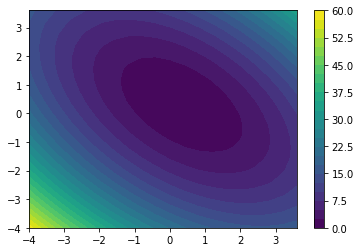

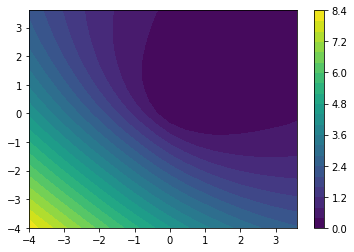

In [10]:
plt.ion()
trainx, trainy = gen_arti(nbex=1000, data_type=0, epsilon=1)
testx, testy = gen_arti(nbex=1000, data_type=0, epsilon=1)
plt.figure()
plot_error(trainx, trainy, mse)
plt.figure(),
plot_error(trainx, trainy, hinge)

Erreur : train 0.003574, test 0.002644


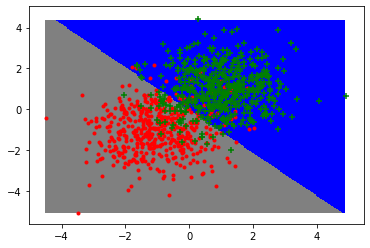

In [11]:
perceptron = Lineaire(hinge, hinge_g, max_iter=1000, eps=0.1)
perceptron.fit(trainx, trainy)
print("Erreur : train %f, test %f" %
          (perceptron.score(trainx, trainy), perceptron.score(testx, testy)))
plt.figure()
plot_frontiere(trainx, perceptron.predict, 200)
plot_data(trainx, trainy)

In [ ]:
plot_trajectory(datax,datay,perceptron,step=10)

Erreur : train 2.498144, test 2.540779


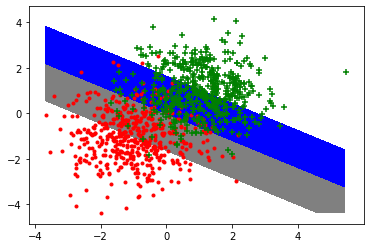

In [257]:
trainx, trainy = gen_arti(nbex=1000, data_type=0, epsilon=1)
testx, testy = gen_arti(nbex=1000, data_type=0, epsilon=1)
trainy.reshape((1, -1))
perceptron = Lineaire(mse, mse_g, max_iter=1000, eps=0.0001)
perceptron.fit(trainx, trainy)
print("Erreur : train %f, test %f" % (perceptron.score(trainx, trainy), perceptron.score(testx, testy)))
plt.figure()
plot_frontiere(trainx, perceptron.predict, 200)
plot_data(trainx, trainy)
plt.show()

In [256]:
def mse(datax,datay,w):
    pred = np.dot(datax, w.T)
    return np.mean((pred-datay)**2)

# Gradient moindres carrés
def mse_g(datax,datay,w):
    M = datay - np.dot(datax, w.T)
    return (-2/np.shape(datax)[0]) * np.sum(np.dot(datax.T, M))

1
101in loss: 0.036
201in loss: 0.025
301in loss: 0.024
401in loss: 0.047
501in loss: 0.077
601in loss: 0.042
701in loss: 0.056
801in loss: 0.057
901in loss: 0.025


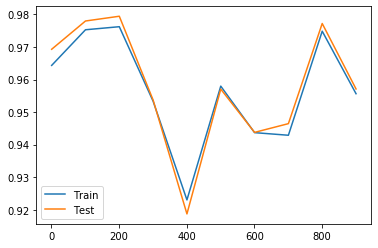

In [200]:
ioff = 0
perceptron = Lineaire(hinge, hinge_g, step, 0.00001)
for iteration in iters:
    print(iteration)
    perceptron.fit(trainx, trainy)
    sc_train[ioff] = 1 -  perceptron.score(trainx, trainy)
    sc_test[ioff] = 1 - perceptron.score(testx, testy)
    ioff+=1
plt.figure()
plt.plot(iters, sc_train)
plt.plot(iters, sc_test)
plt.legend(["Train", "Test"])
plt.show()


## Données USPS

In [202]:
def load_usps(fn):
    with open(fn, "r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split()) > 2]
    tmp = np.array(data)
    return tmp[:, 1:], tmp[:, 0].astype(int)

In [203]:
def show_usps(data):
    plt.imshow(data.reshape((16, 16)), interpolation="nearest", cmap="gray")

In [228]:
def process_USPS_data(X_train, y_train, X_test, y_test,  class1VSclass2, biais=False, scaler=None):
    '''
    - class 1 int 
    - class 2 int or 'all'
    - bias == True   add a bias column to X
    '''

    class1, class2 = class1VSclass2
    X=X_train.copy()
    y=y_train.copy()

    X_t=X_test.copy()
    y_t=y_test.copy()

    
    if(scaler):
        scaler = scaler.fit(X)
        X = scaler.transform(X)
        X_t = scaler.transform(X_t)

    if(biais):
        X = np.hstack((X, np.ones((len(X), 1))))
        X_t = np.hstack((X_t, np.ones((len(X_t), 1))))

    if ( class2 == "all" ):
        y = np.where(y==class1,1,-1)
        y_t = np.where(y_t==class1,1,-1)

        return X, y, X_t, y_t
    else :
        idx = np.concatenate((np.where(y==class1)[0],np.where(y==class2)[0]))
        X, y = X[idx], np.where(y[idx]==class1,1,-1)  
        idx = np.concatenate((np.where(y_t==class1)[0],np.where(y_t==class2)[0]))
        X_t, y_t = X_t[idx], np.where(y_t[idx]==class1,1,-1)  
        return X, y, X_t, y_t
        

In [261]:
datax_train, datay_train = load_usps("data/USPS_test.txt")
datax_test, datay_test = load_usps("data/USPS_train.txt")
    
#6 vs 9    
X_train = datax_train[np.where(np.logical_or(datay_train == 6,datay_train == 9))]
y_train = datay_train[np.where(np.logical_or(datay_train == 6,datay_train == 9))]
labely_train = np.sign(trainy - 7)
X_test = datax_test[np.where(np.logical_or(datay_test == 6,datay_test == 9))]
y_test = datay_test[np.where(np.logical_or(datay_test == 6,datay_test == 9))]
labely_test = np.sign(testy - 7)

process_USPS_data(datax_train, datay_train, datax_test, datay_test,  (6,9), biais=True, scaler=None)

(array([[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,

In [262]:
datax_train.shape

(2007, 256)